In [1]:
!pip install imutils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importing necessary libraries

In [2]:
import numpy as np
import cv2
import os
import imutils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras import regularizers,optimizers
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

Initializing deep neural network caffe model from open CV's neural models 

In [3]:
face_detector = cv2.dnn.readNetFromCaffe("/content/drive/MyDrive/Colab Notebooks/Face Recognition/deploy.prototxt", "/content/drive/MyDrive/Colab Notebooks/Face Recognition/res10_300x300_ssd_iter_140000.caffemodel")

Initializing the facenet model 

In [4]:
face_embedder = cv2.dnn.readNetFromTorch("/content/drive/MyDrive/Colab Notebooks/Face Recognition/nn4.small2.v1.t7")

In [5]:
embedding = []
label = []

Function that runs through all of the images in the given folder. The images are resized using imutils to maintain the aspect ratio. Images are then convereted into the expected shape and mean value from the image channel as it aids the face detection model to detect more accurately. Image blob is the passed on to the model to predict the possible face detections. Only the bounding boxes whose confidence is more than 60 percent is taken as possible detections. The vertices of the bounding box are extracted. Cropped image with the dimensions of the bounding box is then passed onto the facenet network to produce 128-dimensional face imbeddings. Finally the face - embeddings and their corresponding lable are appended to the local list.

In [6]:
def fetch_embeddings(path,name):
  for im in os.listdir(path):
    image = cv2.imread(os.path.join(path,im))
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]
    imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
    face_detector.setInput(imageBlob)
    detections = face_detector.forward()
    if len(detections) > 0:
            i = np.argmax(detections[0, 0, :, 2])
            confidence = detections[0, 0, i, 2]
            if confidence > 0.6:
              box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
              (startX, startY, endX, endY) = box.astype("int")
              face = image[startY:endY, startX:endX]
              (fH, fW) = face.shape[:2]
              if fW < 20 or fH < 20:
                continue
    
    faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(96, 96), (0, 0, 0), swapRB=True, crop=False)
    face_embedder.setInput(faceBlob)
    vec = face_embedder.forward()
    embedding.append(vec)
    label.append(name)

Input images for training is passed onto the fetch_embeddings functions to get their face embeddings. 

In [7]:
fetch_embeddings("/content/drive/MyDrive/Colab Notebooks/Face Recognition/Messi/train",0) #messi
fetch_embeddings("/content/drive/MyDrive/Colab Notebooks/Face Recognition/Ronaldo/Train",1) #ronaldo
fetch_embeddings("/content/drive/MyDrive/Colab Notebooks/Face Recognition/Others/train",2)#pthers

Converting the embedding list into array and reshaping it into the appropriate shape for the feed forward network where it is going to be passed to classify the face.

In [8]:
embedding = np.array(embedding)
embedding = embedding.reshape(embedding.shape[0],embedding.shape[2])
label = np.array(label)

A simple sequential feed shorward network with dropout to classify the faces. Output layer has a softmax activation as we require a probability distribution of all the possible classes. Loss function specified here is sparse categorical crossentropy as this is a mutliclass classification

In [9]:
model = Sequential()
model.add(Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.01),input_shape=(128,)))
model.add(Dropout(0.5))
model.add(Dense(3,activation='softmax'))
model.compile(optimizer=optimizers.Adam(0.001), loss = 'sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy'])

Model is fit to our data and run for 100 epochs , as this is small and simple feed forward network training time is just a matter of few seconds

In [10]:
history = model.fit(embedding,label, epochs = 100, batch_size=5)

Epoch 1/100
11/11 [==============================] - 3s 77ms/step - loss: 1.5950 - sparse_categorical_accuracy: 0.3654
Epoch 2/100
11/11 [==============================] - 0s 2ms/step - loss: 1.5414 - sparse_categorical_accuracy: 0.4423
Epoch 3/100
11/11 [==============================] - 0s 2ms/step - loss: 1.4997 - sparse_categorical_accuracy: 0.4038
Epoch 4/100
11/11 [==============================] - 0s 2ms/step - loss: 1.4164 - sparse_categorical_accuracy: 0.6154
Epoch 5/100
11/11 [==============================] - 0s 2ms/step - loss: 1.3858 - sparse_categorical_accuracy: 0.5962
Epoch 6/100
11/11 [==============================] - 0s 2ms/step - loss: 1.3620 - sparse_categorical_accuracy: 0.5385
Epoch 7/100
11/11 [==============================] - 0s 2ms/step - loss: 1.3216 - sparse_categorical_accuracy: 0.5962
Epoch 8/100
11/11 [==============================] - 0s 2ms/step - loss: 1.2978 - sparse_categorical_accuracy: 0.6154
Epoch 9/100
11/11 [==============================] - 0s

Function to find the embeddings and also recognize the person's face for our test data and plotting the bounding box of our detection with their corresponding class's probability

In [11]:
def fetch_embeddings_image(path):

  image = cv2.imread(path)
  image = imutils.resize(image, width=600)
  (h, w) = image.shape[:2]
  imageBlob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0, (300, 300),(104.0, 177.0, 123.0), swapRB=False, crop=False)
  face_detector.setInput(imageBlob)
  detections = face_detector.forward()
  if len(detections) > 0:
      i = np.argmax(detections[0, 0, :, 2])
      confidence = detections[0, 0, i, 2]
      if confidence > 0.6:
        box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
        (startX, startY, endX, endY) = box.astype("int")
        face = image[startY:endY, startX:endX]
        (fH, fW) = face.shape[:2]

  faceBlob = cv2.dnn.blobFromImage(face, 1.0 / 255,(96, 96), (0, 0, 0), swapRB=True, crop=False)
  face_embedder.setInput(faceBlob)
  vec = face_embedder.forward()
  vec = np.array(vec)
  print(vec.shape)
  result = model.predict(vec)[0]
  print(result)
  k = np.argmax(result)
  if k==0:
    text = "messi"
  elif k==1:
    text = "ronaldo"
  else :
    text = "other"
  text_final = "{}: {:.2f}%".format(text, result[k] * 100)
  y = startY - 10 if startY - 10 > 10 else startY + 10
  cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 2)
  cv2.putText(image, text_final, (startX, y),cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
  cv2_imshow( image)
  cv2.waitKey(0)


(1, 128)
1/1 [==============================] - 0s 62ms/step
[0.19345596 0.10646909 0.7000749 ]


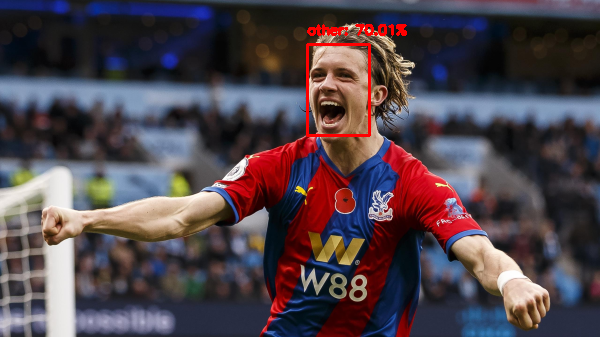

In [12]:
fetch_embeddings_image("/content/drive/MyDrive/Colab Notebooks/Face Recognition/Others/test/10.jpg")

(1, 128)
1/1 [==============================] - 0s 35ms/step
[0.02649737 0.9128494  0.06065317]


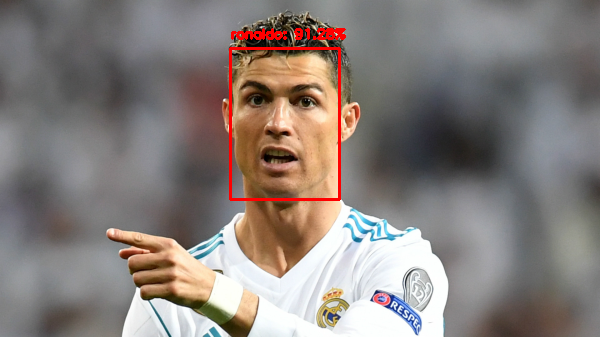

In [13]:
fetch_embeddings_image("/content/drive/MyDrive/Colab Notebooks/Face Recognition/Ronaldo/test/14.jpg")

(1, 128)
1/1 [==============================] - 0s 14ms/step
[0.7552042  0.03644461 0.20835118]


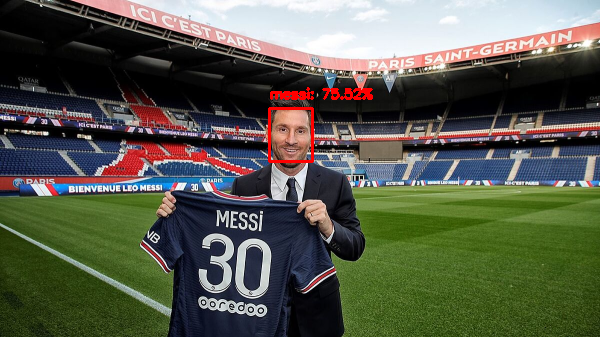

In [14]:
fetch_embeddings_image("/content/drive/MyDrive/Colab Notebooks/Face Recognition/Messi/test/20.jpg")